In [ ]:
!pip install pycocotools
!pip install scikit-image

  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached tifffile-2025.10.16-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 39.1 MB/s eta 0:00:001m35.0 MB/s eta 0:00:01
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2025.10.16-py3-none-any.whl (231 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image]0m 3/4 [scikit-image]


In [ ]:
import torch, torch.nn as nn, pandas as pd, dotenv, numpy as np, os
from pycocotools.coco import COCO
from pathlib import Path
from matplotlib import pyplot as plt
from skimage import io
from torch.utils.data import Dataset, DataLoader, Subset

dotenv.load_dotenv()
data_path = Path(os.getenv("DATAPATH"))

In [ ]:
# Hyperparameters
batch_size = 32

In [ ]:
class DS(Dataset):
    def __init__(self, annotation_file, categories=['horse']):
        super().__init__()
        self.coco = COCO(data_path/"annotations"/annotation_file)
        self.category_ids = self.coco.getCatIds(categories)
        self.image_ids = self.coco.getImgIds(catIds=self.category_ids)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        img_id = [self.image_ids[index]]
        annotation_ids = coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)

        return (
            io.imread(data_path/"val2017"/self.coco.loadImgs(img_id)[0]['file_name']),
            coco.loadAnns(annotation_ids)
        )

In [ ]:
ds_val = DS('instances_val2017.json')
dl_val = DataLoader(ds_val, batch_size)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


('1. person', 2693)
('62. chair', 580)
('3. car', 535)
('67. dining table', 501)
('47. cup', 390)


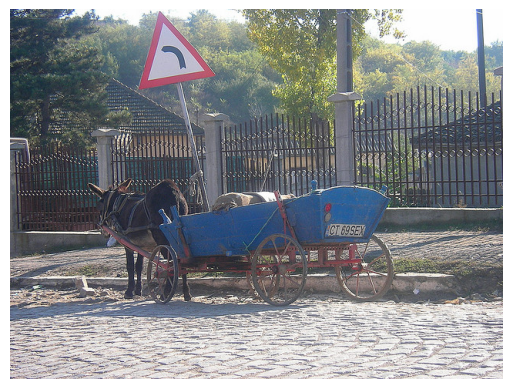

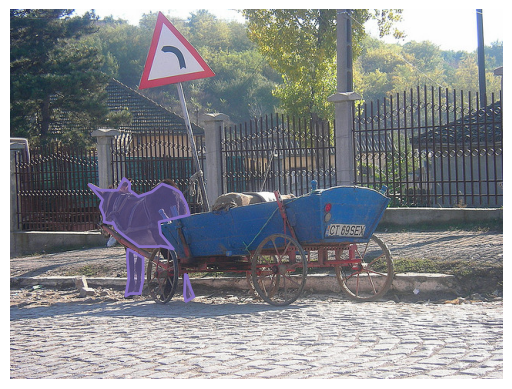

In [ ]:
# COCO API Usage
# https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
coco = ds_val.coco

categories = coco.loadCats(coco.getCatIds())
counts = {f'{category['id']}. {category['name']}': len(coco.getImgIds(catIds=[category['id']])) for category in categories}
best = list(counts.items())
best.sort(key = lambda item: -item[1])
best = map(str, best[:5])
# (classId. className, examples)
print('\n'.join(best))

# load and display image
img, annotations = ds_val[0]
plt.axis('off')
plt.imshow(img)
plt.show()

# load and display instance annotations
plt.imshow(img)
plt.axis('off')
coco.showAnns(annotations)

In [ ]:
def crop(tensor: torch.Tensor, size: int):
    offset = (tensor.shape[1] - size) // 2
    return tensor[:, offset:(offset+size), offset:(offset+size)]

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        s = nn.Sequential

        self.contracting_layers = [
            s(
                nn.Conv2d(3, 64, 3),
                nn.ReLU(),
                nn.Conv2d(64, 64, 3),
                nn.ReLU()
            ),
            s(
                nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3),
                nn.ReLU(),
                nn.Conv2d(128, 128, 3),
                nn.ReLU(),
            ),
            s(
                nn.MaxPool2d(2),
                nn.Conv2d(128, 256, 3),
                nn.ReLU(),
                nn.Conv2d(256, 256, 3),
                nn.ReLU()
            ),
            s(
                nn.MaxPool2d(2),
                nn.Conv2d(256, 512, 3),
                nn.ReLU(),
                nn.Conv2d(512, 512, 3),
                nn.ReLU()
            )
        ]

        self.center = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(512, 1024, 3),
            nn.Conv2d(1024, 1024, 3),
            nn.ConvTranspose2d(1024, 512, 2, 2)
        )

        self.expanding_layers = []

        self.final = nn.Conv2d(64, 2, 1)

    def forward(self, x):
        layer_outputs = [l(x) for l in self.contracting_layers]
        x = self.center(layer_outputs[-1])

        for i, layer in enumerate(self.expanding_layers, 1):
            x = layer(torch.concat(crop(layer_outputs[-i]), x))


In [1]:
# base CNN model
import tensorflow as tf

def generate_base_CNN(num_classes=2):
  model = tf.keras.Sequential([
      # first layer
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPool2D(pool_size=2),

      # second layer
      tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
      tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPool2D(pool_size=2),

      # third layer
      tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
      tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPool2D(pool_size=2),

      # fourth layer
      tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu'),
      tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu'),

      # output layer
      tf.keras.layers.Conv2D(num_classes, kernel_size=1, activation='softmax'),   # binary classification
  ])